# EleMLDS - Exercise 4 Part II: Logistic Regression
In this exercise, you will implement training & evaluation code for a binary logistic regression model, using both first order and second order methods.

Make sure to replace all parts that say
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Happy coding!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
def load_data(name):
    data_file = np.load(f"{name}.npz")
    data = {s: data_file[s] for s in ("data", "labels")}
    data["labels"] = np.where(data["labels"] > 0, 1, 0)
    return data

## Q1: Sigmoid activation and Cross-Entropy Loss
**a) (2 points)** First, we will implement the sigmoid activation function and the cross-entropy loss used to train the logistic regression model.

Recall that the sigmoid is defined as $\sigma(a) = \frac{1}{1 + e^{-a}}$, and the (binary) cross-entropy loss can be written as 

$$
\mathcal{L}(x, \hat x) = -\sum_{n=0}^N (x \ln(\hat x) + (1 - x) \ln(1 - \hat x),
$$

denoting the predictions with $\hat x$ and the label with $x$.

In [3]:
def sigmoid(x):
    # applies the sigmoid function to the input
    return 1 / (1 + np.exp(-x))


def cross_entropy(x, t):
    # computes the binary cross-entropy error
    # Input
    #  x : array of model outputs (N,)
    #  t : array of labels, (0 or 1)
    # Output
    #  cross-entropy error between x and t

    # YOUR CODE HERE
    return -np.sum(t * np.log(x) + (1 - t) * np.log(1 - x))

**b) (2 points)** Now complete the two functions below.
`apply` should compute the posterior probability of the data given the model, and `classify` should output the class prediction for each sample (i.e. either 0 or 1).

Assume that the bias is already part of the weight vector $\mathbf{w}$.

In [18]:
def apply(w, X):
    # applies the model to the dataset and returns the predicted posterior probability
    # Input
    #  w : model parameters (D,)
    #  X : data (N, D) where N is the number of samples and D is the number of features (N, D) where N is the number of samples and D is the number of features
    # Output
    #  posterior probability for every datapoint (N, )

    return sigmoid(X @ w)


def classify(w, X):
    # applies the model and classifies datapoints
    # Input
    #  w : model parameters (D,)
    #  X : data (N, D) where N is the number of samples and D is the number of features (N, D) where N is the number of samples and D is the number of features
    # Output
    #  predicted class label for every datapoint (0 or 1) (N, )

    # YOUR CODE HERE
    return np.array(apply(w, X) > np.float64(0.5), dtype=int)

The code cell below loads a pretrained model and applies it to one of the test sets. When your implementation is correct, you should get an accuracy above 0.95.

In [25]:
check_data = np.load("check_data.npz")
data = check_data["data"]
labels = check_data["labels"]
weight = check_data["weight"]

data = np.hstack((np.ones((data.shape[0], 1)), data))
test_accuracy = np.mean(classify(weight, data) == labels)

print(f"Accuracy of the classify function : {test_accuracy:.4f}")

Accuracy of the classify function : 0.9737


In the next cell, we provide some evaluation and visualization utilities.

In [26]:
def plot_contour(fun):
    # make a regular grid over the whole plot
    x, y = np.linspace(*plt.xlim(), 200), np.linspace(*plt.ylim(), 200)
    xx, yy = np.meshgrid(x, y)
    grid = np.c_[xx.ravel(), yy.ravel()]
    # evaluate function on grid
    res = fun(grid).reshape(*xx.shape)

    # plot contour lines (=decision boundary) and filled contours over whole plot
    plt.contourf(
        xx, yy, res, levels=[-np.inf, 0.5, np.inf], colors=["yellow", "blue"], alpha=0.2
    )
    plt.contour(xx, yy, res, levels=[0.5], colors="k")
    # print(res.min(), res.max(), (res**2).sum())


def plot_(data, labels, params=None, basis_fun=None):
    # Plot the data points and the decision line
    plt.subplot()

    class1, class2 = data[labels > 0.5], data[labels < 0.5]
    plt.scatter(*class1.T, c="blue", marker="x")
    plt.scatter(*class2.T, c="orange", marker="o")

    if params is not None:
        # Quick and hacky way to fix the y-axis limits
        plt.ylim(plt.ylim())

        if basis_fun:
            # evaluate decision function on grid and plot contours
            plot_contour(lambda grid: apply(params, basis_fun(grid)))
        else:
            w, b = params[1:], params[0]
            xmax = data[:, 0].max(0)
            xmin = data[:, 0].min(0)
            # just plot a line
            y = lambda x: -(w[0] * x + b) / w[1]
            plt.plot([xmin, xmax], [y(xmin), y(xmax)], c="k")

    plt.show()


def eval_logreg(w, data, labels, phi=None, basis_fun=None):
    if phi is None:
        phi = lambda x: x

    pred = classify(w, phi(data))
    acc = np.mean(pred == labels)
    print(f"Accuracy: {acc:.5f}")

    plot_(data, labels, params=w, basis_fun=basis_fun)

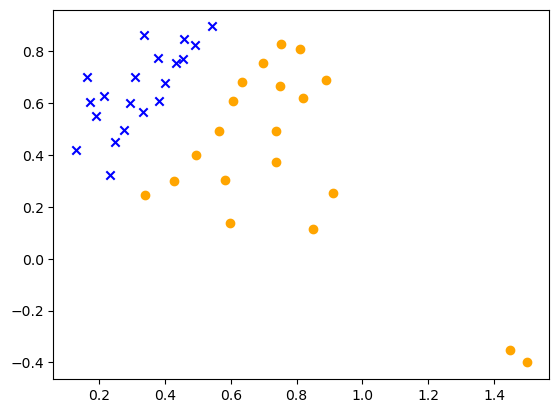

In [32]:
data_ = load_data("lc_train")
train_data, train_labels = data_["data"], data_["labels"]
data_ = load_data("lc_test")
test_data, test_labels = data_["data"], data_["labels"]

outlier_train_data = np.append(train_data, [[1.5, -0.4], [1.45, -0.35]], axis=0)
outlier_train_labels = np.append(train_labels, [[0], [0]])

plot_(outlier_train_data, outlier_train_labels)

## Q2: Optimization methods
**a) (2 points)** In the second part of this exercise, you will implement the training procedure.
First, implement the update rule of gradient descent in the function `first_order_update`.
Recall that gradient descent updates the weights via

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta \nabla E(w)
$$

and the gradient of the logistic regression model (sigmoid activation + cross-entropy error) is

$$
\nabla E(\mathbf{w}) = \sum_{n=1}^N (y_n - t_n)\phi_n
$$

In [41]:
def first_order_update(w, X, t, eta):
    # computes the gradient descent update for the given parameters
    # Input
    #  w : current model parameters (D,)
    #  X : data (N, D) where N is the number of samples and D is the number of features (N, D) where N is the number of samples and D is the number of features
    #  t : labels (N,)
    #  eta : step size of gradient descent (scalar)
    # Output
    #  new model parameters (D,)
    
    # Predictions of current model
    predictions = apply(w, X)

    # Gradient = ((y_n - t_n) * phi_n)
    # X includes the bias, w includes weight for bias -> automatically takes the bias into account
    gradient = (predictions - t) @ X

    # Update the weights
    # w^(tau+1) = w^(tau) - eta * Gradient
    return w - eta * gradient

We have provided a training loop below.
Have a look at it to see how we utilize the functions you wrote so far.

In [42]:
def train(data, labels, err_fun, iters, update_fun, err_thresh=1e-3):
    # assume data is already transformed with basis function
    w = np.zeros(data.shape[1])

    errors, norms = [], []
    for _ in range(iters):
        result = apply(w, data)
        err = err_fun(result, labels)
        errors.append(err)
        norms.append(np.sum(w**2))
        if err < err_thresh:
            break
        w = update_fun(w, data, labels)

    l1 = plt.plot(errors)
    plt.title("Error and weight norm over iterations")
    plt.ylabel("Error")
    plt.twinx()
    plt.ylabel("Weight norm")
    l2 = plt.plot(norms, c="orange")
    plt.xlabel("Iteration")
    plt.legend(l1 + l2, ["error", "norm"])
    plt.show()

    return w

Run the code below to test your implementation; what accuracy do you achieve? What do you notice about the model weights?

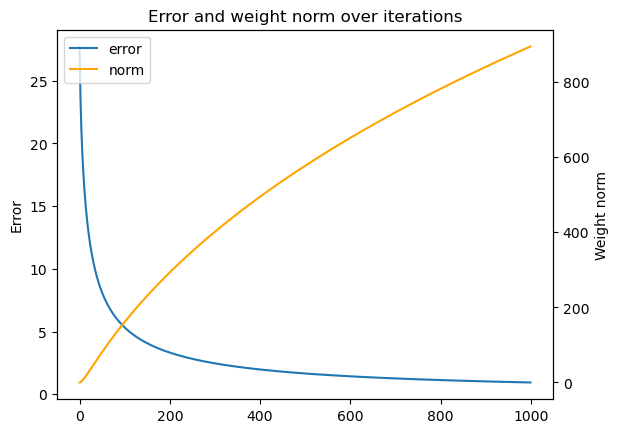

Accuracy: 1.00000


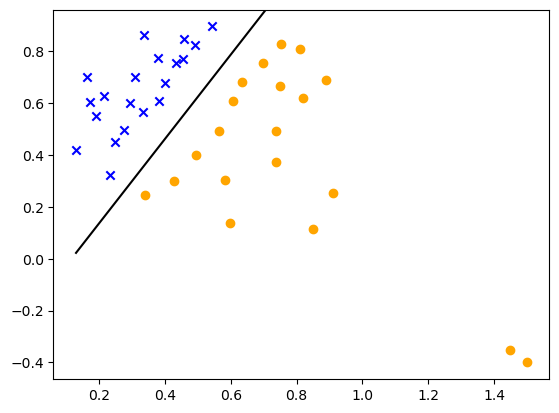

Accuracy: 0.94595


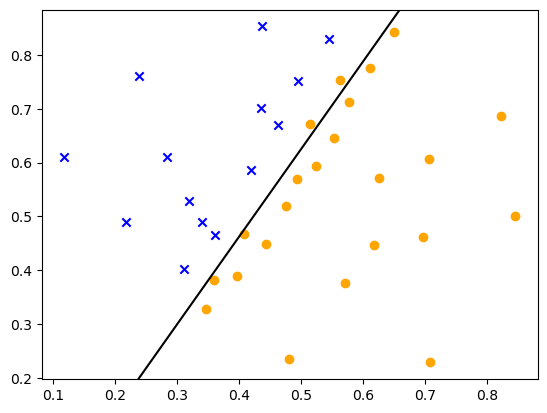

In [43]:
def add_bias(X):
    N = len(X)
    return np.concatenate([np.ones((N, 1)), X], axis=-1)


eta = 0.1
iters = 1000
phi = add_bias

grad_descent_update = partial(first_order_update, eta=eta)
w = train(
    phi(outlier_train_data),
    outlier_train_labels,
    cross_entropy,
    iters,
    grad_descent_update,
)
eval_logreg(w, outlier_train_data, outlier_train_labels, phi)
eval_logreg(w, test_data, test_labels, phi)

**b) (4 points)** Now complete the cell below to implement the IRLS update equations.

**Hint:** the matrix $R$ is not always invertible. We can instead use the following trick: finding $A^{-1}b$ is equivalent to solving $Ax = b$ for $x$; finding a good approximation for $x$ is relatively easy, while inverting the matrix is impossible. With numpy, we would use `np.linalg.lstsq(A, b)` to get the least-squares approximation to $x$.

In [57]:
def second_order_update(w, X, t):
    # compute the second-order (IRLS) update for the given parameters
    # Input
    #  w : current model parameters (D,)
    #  X : data (N, D) where N is the number of samples and D is the number of features (N, D) where N is the number of samples and D is the number of features
    #  t : labels (N,)
    # Output
    #  new model parameters (D,)
    
    # Current predictions
    y = apply(w, X)

    # R matrix: diag. matrix of weights
    R = np.diag(y * (1 - y))

    # b for solving R x = b
    b = y - t

    # Solve R x = b, equivalent to R^-1 b -> x = (R^−1(y-t))
    x, _, _, _ = np.linalg.lstsq(R, b, rcond=None)

    # Calc z vector with lstsq solution x -> z = Xw -(R^−1(y-t))
    z = (X @ w) - x

    # solve (X.T R X)new_w = X.T R z ->  (X.T @ R @ X)^-1 X.T R z
    A = X.T @ R @ X
    b = X.T @ R @ z

    # Compute the new weights
    new_w, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    return new_w

Now train and evaluate a logistic regression model using this function.
Notice that the second-order updater needs fewer iterations than the first-order method.

/var/folders/1c/ycrp9trx0pbc1k7f3dp67vz00000gn/T/ipykernel_26360/1954932901.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.sum(t * np.log(x) + (1 - t) * np.log(1 - x))
/var/folders/1c/ycrp9trx0pbc1k7f3dp67vz00000gn/T/ipykernel_26360/1954932901.py:15: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(t * np.log(x) + (1 - t) * np.log(1 - x))


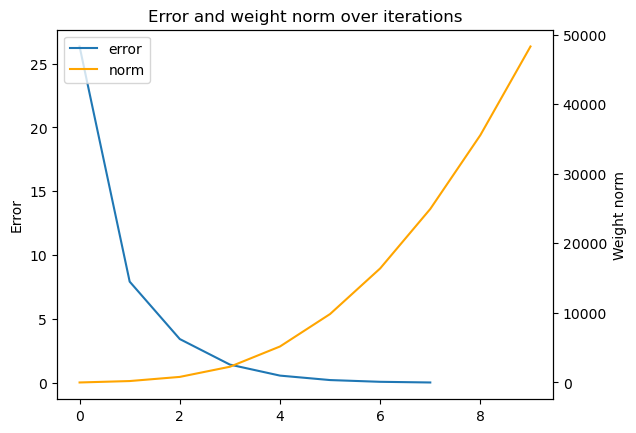

Accuracy: 0.95000


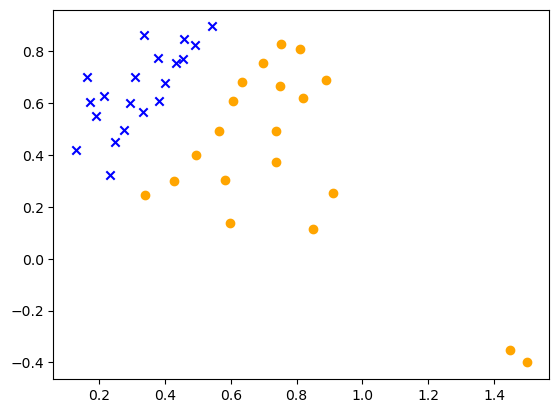

Accuracy: 1.00000


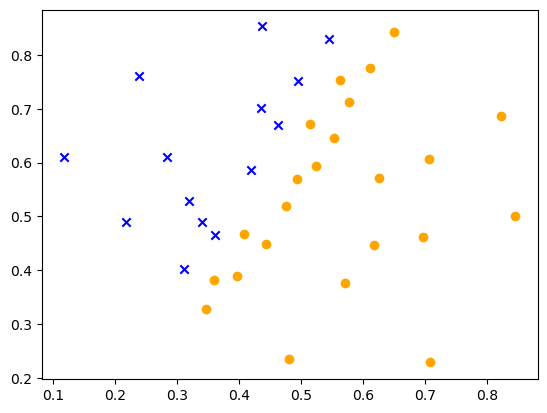

In [58]:
iter_second_order = 10
w = train(
    phi(train_data), train_labels, cross_entropy, iter_second_order, second_order_update
)
eval_logreg(w, outlier_train_data, outlier_train_labels, phi)
eval_logreg(w, test_data, test_labels, phi)

### Test different datasets

Now, we will evaluate the weight update algorithm on various datasets to examine its performance.

In [59]:
def poly(x, d):
    feature = np.stack(
        [x[:, 0] ** i * x[:, 1] ** j for i in range(d + 1) for j in range(d + 1 - i)],
        axis=-1,
    )
    return feature


def play_around(phi, update_fun, dataset, iters):
    data_ = load_data(f"{dataset}_train")
    train_data, train_labels = data_["data"], data_["labels"]
    data_ = load_data(f"{dataset}_test")
    test_data, test_labels = data_["data"], data_["labels"]

    w = train(phi(train_data), train_labels, cross_entropy, iters, update_fun, 2.5)
    eval_logreg(w, train_data, train_labels, phi, phi)
    eval_logreg(w, test_data, test_labels, phi, phi)

To modify the degree of the polynomial kernel and select different update algorithms, you can adjust the values of the following variables:

- `d`: Represents the degree of the polynomial kernel. It should be set to a positive integer.
- `eta`: The learning rate (for the first-order udpate)

Test out different configurations on different datasets!

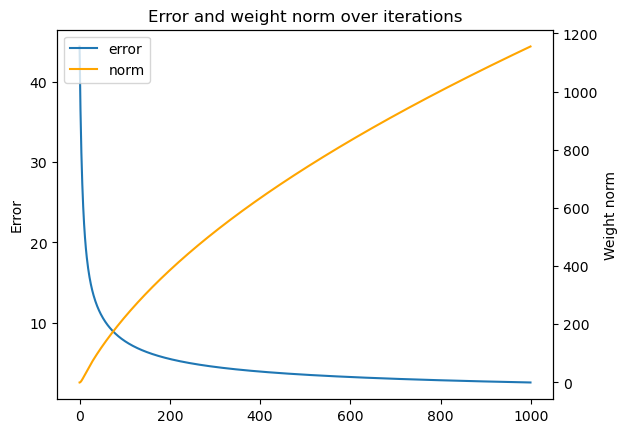

Accuracy: 0.98438


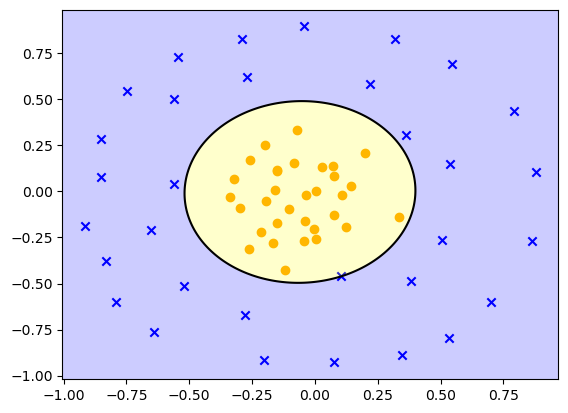

Accuracy: 0.78000


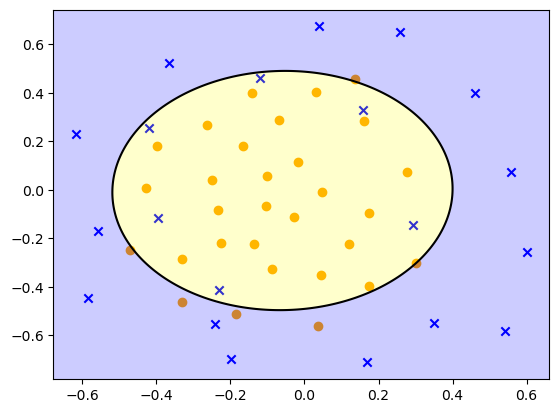

In [60]:
iters = 1000
eta = 0.1
d = 2
phi = partial(poly, d=d)
GD = partial(first_order_update, eta=eta)
IRLS = partial(second_order_update)

# possible values for dataset are:
# lc, circles, CC, XOR
play_around(
    phi=phi,
    update_fun=GD,
    dataset="circles",
    iters=iters,
)